In [30]:
import pandas as pd
import numpy as np
import seaborn as sns

In [31]:
file = 'SAV/data/All_SAV_Parameters-2023-Jun-05.txt'
SAV = pd.read_csv(file, sep='|',na_values=['NULL','','NA'])

C:\Users\Hill_T\AppData\Local\Temp\ipykernel_21636\1126649852.py:2: DtypeWarning: Columns (17,23) have mixed types. Specify dtype option on import or set low_memory=False.
  SAV = pd.read_csv(file, sep='|',na_values=['NULL','','NA'])


In [32]:
SAV.shape

(4666535, 28)

In [33]:
SAV['BB'] = SAV[SAV.ParameterName=='Braun Blanquet Score']['ResultValue']
SAV['mBB'] = SAV[SAV.ParameterName=='Modified Braun Blanquet Score']['ResultValue']
SAV['PC'] = SAV[SAV.ParameterName=='Percent Cover']['ResultValue']
SAV['PO'] = SAV[SAV.ParameterName=='Percent Occurrence']['ResultValue']
SAV['SC'] = SAV[SAV.ParameterName=='Shoot Count']['ResultValue']
SAV['PA'] = SAV[SAV.ParameterName=='Presence/Absence']['ResultValue']

In [34]:
SAV[SAV.CommonIdentifier=='Total_SAV'].CommonIdentifier = 'Total SAV'
SAV_sum = SAV.groupby('ManagedAreaName').agg(n_yr=('Year', lambda x: len(np.unique(x))), yrs=('Year', lambda x: sorted(np.unique(x).tolist()))).reset_index()

C:\Users\Hill_T\AppData\Local\Temp\ipykernel_21636\2792964719.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SAV[SAV.CommonIdentifier=='Total_SAV'].CommonIdentifier = 'Total SAV'


In [35]:
SAV_sum.shape

(29, 3)

In [36]:
SAV2 = SAV[(~pd.isna(SAV['BB'])) | (~pd.isna(SAV['mBB'])) | (~pd.isna(SAV['PC'])) | (~pd.isna(SAV['PO']))]

SAV2 = SAV2[(SAV2['BB'] >= 0) & (SAV2['BB'] <= 5) | pd.isna(SAV2['BB'])]
SAV2 = SAV2[(SAV2['mBB'] >= 0) & (SAV2['mBB'] <= 5) | pd.isna(SAV2['mBB'])]
SAV2 = SAV2[(SAV2['PC'] >= 0) & (SAV2['PC'] <= 100) | pd.isna(SAV2['PC'])]
SAV2 = SAV2[(SAV2['PO'] >= 0) & (SAV2['PO'] <= 100) | pd.isna(SAV2['PO'])]
SAV2 = SAV2[SAV2['Month'].isin(list(range(4, 11)))]

In [37]:
SAV2.shape

(2074132, 34)

In [38]:
SAV2['BB_all'] = np.nan

In [39]:
SAV2.loc[~SAV2['BB'].isna(),'BB_all'] = np.select(
    [(SAV2[~SAV2['BB'].isna()]['BB'] == 0),(SAV2[~SAV2['BB'].isna()]['BB'] > 0) & (SAV2[~SAV2['BB'].isna()]['BB'] <= 1),(SAV2[~SAV2['BB'].isna()]['BB'] > 1)], 
    [0, 1, np.round(SAV2[~SAV2['BB'].isna()]['BB'])]
)

SAV2.loc[~SAV2['mBB'].isna(), 'BB_all'] = np.select(
    [(SAV2[~SAV2['mBB'].isna()]['mBB']==0),
        (SAV2[~SAV2['mBB'].isna()]['mBB'] > 0) & (SAV2[~SAV2['mBB'].isna()]['mBB'] <= 1),
        (SAV2[~SAV2['mBB'].isna()]['mBB'] > 1)],
    [0, 1, np.round(SAV2[~SAV2['mBB'].isna()]['mBB'])]
)

pc_na = SAV2.loc[~SAV2['PC'].isna()]['PC']
pc_conditions = [
    (pc_na==0),
    ((pc_na > 0)&(pc_na <= (2.5+(15-2.5)/2))),
    (pc_na <= (2.5+(15-2.5)+(37.5-15)/2)),
    (pc_na <= (2.5+(15-2.5)+(37.5-15)+(62.5-37.5)/2)),
    (pc_na <= (2.5+(15-2.5)+(37.5-15)+(62.5-37.5)+(87.5-62.5)/2)),
    (pc_na > (2.5+(15-2.5)+(37.5-15)+(62.5-37.5)+(87.5-62.5)/2))
]
SAV2.loc[~SAV2['PC'].isna(), 'BB_all'] = np.select(pc_conditions,[0, 1, 2, 3, 4, 5])

In [40]:
SAV2.shape

(2074132, 35)

In [41]:
bb_all_na = SAV2.loc[~SAV2['BB_all'].isna()]
SAV2.loc[~SAV2['BB_all'].isna(), 'BB_pct'] = np.select(
    [
        bb_all_na['BB_all'] == 0,
        (bb_all_na['BB_all'] > 0) & (bb_all_na['BB_all'] <= 0.1),
        (bb_all_na['BB_all'] > 0.1) & (bb_all_na['BB_all'] <= 0.5),
        (bb_all_na['BB_all'] > 0.5) & (bb_all_na['BB_all'] <= 1),
        (bb_all_na['BB_all'] > 1) & (bb_all_na['BB_all'] <= 2),
        (bb_all_na['BB_all'] > 2) & (bb_all_na['BB_all'] <= 3),
        (bb_all_na['BB_all'] > 3) & (bb_all_na['BB_all'] <= 4),
        (bb_all_na['BB_all'] > 4) & (bb_all_na['BB_all'] <= 5)
    ],
    [
        0,
        np.interp(bb_all_na['BB_all'], [0, 0.1], [0, 0.02]),
        np.interp(bb_all_na['BB_all'], [0.1, 0.5], [0.02, 0.1]),
        np.interp(bb_all_na['BB_all'], [0.5, 1], [0.1, 2.5]),
        np.interp(bb_all_na['BB_all'], [1, 2], [2.5, 15]),
        np.interp(bb_all_na['BB_all'], [2, 3], [15, 37.5]),
        np.interp(bb_all_na['BB_all'], [3, 4], [37.5, 62.5]),
        np.interp(bb_all_na['BB_all'], [4, 5], [62.5, 87.5])
    ],
    default=np.nan
)

SAV2['BB_pct'] = SAV2['BB_pct'].astype(float)
SAV2['BB_all'] = pd.Categorical(SAV2['BB_all'])

SAV2.loc[~SAV2['PO'].isna(), 'method'] = "Percent Occurrence"
SAV2.loc[~SAV2['BB'].isna(), 'method'] = "Braun Blanquet"
SAV2.loc[~SAV2['mBB'].isna(), 'method'] = "Modified Braun Blanquet"
SAV2.loc[~SAV2['PC'].isna(), 'method'] = "Percent Cover"

In [42]:
# Update PA where BB_all is not NA
SAV2.loc[~SAV2['BB_all'].isna(), 'PA'] = np.where(SAV2.loc[~SAV2['BB_all'].isna()]['BB_all'] == 0, 0, 1)

# Update PA where PO is not NA
SAV2.loc[~SAV2['PO'].isna(), 'PA'] = np.where(SAV2.loc[~SAV2['PO'].isna()]['PO'] == 0, 0, 1)

# Calculate relyear
SAV2['relyear'] = SAV2['Year'] - SAV2['Year'].min()

In [43]:
# Filter SAV2 for SpeciesGroup1 values "Seagrass" or "Macroalgae"
SAV3 = SAV2[SAV2['SpeciesGroup1'].isin(['Seagrass', 'Macroalgae'])].copy()

In [44]:
# Temporary fix for ProgramID values 570 and 571
SAV3.loc[(SAV3['CommonIdentifier'] == 'Total SAV'), 'CommonIdentifier'] = 'Total seagrass'

# Temporary fix for records with CommonIdentifier as "Drift algae"
SAV3.loc[SAV3['CommonIdentifier'] == 'Drift algae', 'Drift_Attached'] = 'Drift'

In [45]:
SAV3.CommonIdentifier = SAV3.CommonIdentifier.astype(str)

In [46]:
species_reject = ["All", "NA",
                  "Vallisneria americana", "Najas guadalupensis",
                  "Hydrilla verticillata", "Potamogeton pusillus",
                  "Zannichellia palustris"]

In [47]:
# Update the 'analysisunit_halid' column based on conditions
SAV3['analysisunit_halid'] = (
    SAV3['CommonIdentifier']
    .where(~SAV3['CommonIdentifier'].isin(species_reject), np.nan)
    .where(~(SAV3['CommonIdentifier'].str.contains('Halophila') & SAV3['SpeciesName'].isna()), "Unidentified Halophila")
    .where(SAV3['SpeciesGroup1'] == "Seagrass", SAV3['Drift_Attached'])
)

# Update the 'analysisunit' column based on conditions
SAV3['analysisunit'] = (
    SAV3['CommonIdentifier']
    .where(~SAV3['CommonIdentifier'].isin(species_reject), np.nan)
    .where(~SAV3['CommonIdentifier'].str.contains('Halophila'), "Halophila spp.")
    .where(SAV3['SpeciesGroup1'] == "Seagrass", SAV3['Drift_Attached'])
)

# Update analysisunit_halid and analysisunit columns for records with Drift_Attached not NA
SAV3.loc[~SAV3['Drift_Attached'].isna(), 'analysisunit_halid'] = SAV3.loc[~SAV3['Drift_Attached'].isna(), 'analysisunit_halid'] + ' algae'
SAV3.loc[~SAV3['Drift_Attached'].isna(), 'analysisunit'] = SAV3.loc[~SAV3['Drift_Attached'].isna(), 'analysisunit'] + ' algae'

In [48]:
# Remove rows with NA in analysisunit column
SAV4 = SAV3[~SAV3['analysisunit'].isna()].copy()

# Optionally, if you want to reset the index of the filtered DataFrame
SAV4.shape

(950857, 40)

In [49]:
# Save SAV4 as RDS file / pickle
# SAV4.to_pickle("SAV/output/SAV_DataUsed.pkl")

# Save SAV4 as CSV file
SAV4.to_csv("SAV/output/SAV_DataUsed.txt", sep='|', index=False)

In [20]:
# Calculate SAV4_sum by grouping method and ManagedAreaName
SAV4_sum = SAV4.groupby(['method', 'ManagedAreaName']).agg(n_yr=('Year', lambda x: len(np.unique(x))),
                                                          yrs=('Year', lambda x: sorted(np.unique(x)))).reset_index()

In [29]:
SAV4[(SAV4.ManagedAreaName=='Indian River-Vero Beach to Ft. Pierce')&(SAV4.Year==1994)&(SAV4.method=='Percent Occurrence')&(SAV4.analysisunit!='Drift algae')].groupby(['analysisunit'])['ResultValue'].mean()

analysisunit
Halodule wrightii        34.604396
Halophila spp.            0.443223
Ruppia maritima           0.000000
Syringodium filiforme    18.010989
Thalassia testudinum     21.725275
Name: ResultValue, dtype: float64

### PLOTTING ###

In [22]:
import matplotlib.pyplot as plt

def addfits_blacktrendlines(models, plot_i, param):
    aucol = plot_i.data.columns[0]
    if len(models) == 1:
        i = plot_i.data.iloc[0]['ManagedAreaName']
        filtered_data = SAV4[(SAV4['ManagedAreaName'] == i) & (~SAV4[param].isna()) & (SAV4[aucol] == models[0].data[aucol].unique())]
        plot_i += plt.geom_line(data=filtered_data,
                                mapping=plt.aes(x='relyear', y=models[0].predict(level=0)),
                                color='#000099', size=0.75, alpha=0.7, inherit_aes=False)
        return plot_i

In [23]:
EDA = "plots"
Analyses = ['BB_pct','PA']

In [219]:
# Empty DataFrame to store names of any failed models
failedmods = pd.DataFrame(columns=["model", "error"])

# Create a table of the proportion of present SAV types by managed area and year
props_halid = (SAV4[~SAV4['analysisunit_halid'].str.contains(r'Total|Drift|spp\.', na=False) & ~SAV4['PA'].isna()]
              .groupby(['ManagedAreaName', 'analysisunit_halid', 'relyear'])
              .agg(n_P=('PA', 'sum'), ntot_PA=('PA', 'count'))
              .assign(prop_P=lambda x: x['n_P'] / x['ntot_PA']))

props = (SAV4[~SAV4['analysisunit'].str.contains(r'Total|Drift|decipiens|engelmannii|johnsonii|Unidentified', na=False) & ~SAV4['PA'].isna()]
         .groupby(['ManagedAreaName', 'analysisunit', 'relyear'])
         .agg(n_P=('PA', 'sum'), ntot_PA=('PA', 'count'))
         .assign(prop_P=lambda x: x['n_P'] / x['ntot_PA']))

props_halid.reset_index(inplace=True)
props.reset_index(inplace=True)

props_halid['n_allsp_P'] = props_halid.groupby(['ManagedAreaName', 'relyear'])['n_P'].transform('sum')
props_halid['sp_prop'] = props_halid['n_P'] / props_halid['n_allsp_P']
props_halid['sp_pct'] = props_halid['sp_prop'] * 100

props['n_allsp_P'] = props.groupby(['ManagedAreaName', 'relyear'])['n_P'].transform('sum')
props['sp_prop'] = props['n_P'] / props['n_allsp_P']
props['sp_pct'] = props['sp_prop'] * 100

props_halid = props_halid.rename(columns={'analysisunit_halid': 'analysisunit'})
props2 = pd.concat([props_halid, props]).drop_duplicates()
props2.sort_values(by=['ManagedAreaName', 'relyear', 'analysisunit'], inplace=True)
props = props2.copy()

props.to_csv("SAV/output/props.txt", sep='|', index=False)

In [26]:
spcollist=["#005396","#0088B1","#00ADAE","#65CCB3","#AEE4C1","#FDEBA8","#F8CD6D","#F5A800","#F17B00"]

In [27]:
spp = ["Halodule wrightii", "Halophila decipiens", "Halophila engelmannii", "Halophila johnsonii", 
         "Halophila spp.", "Ruppia maritima", "Syringodium filiforme", "Thalassia testudinum", "Attached algae"]

spp_common = ["Halophila spp.", "Johnson's seagrass", "Manatee grass", "Paddle grass", 
                "Shoal grass", "Star grass", "Turtle grass", "Widgeon grass", "Attached algae"]

In [30]:
usenames = "common"  # alternative is "scientific"
spcols = {}
if usenames == "common":
    spcols = dict(zip(spp_common, spcollist))
else:
    spcols = dict(zip(spp, spcollist))
spcols

{'Halophila spp.': '#005396',
 "Johnson's seagrass": '#0088B1',
 'Manatee grass': '#00ADAE',
 'Paddle grass': '#65CCB3',
 'Shoal grass': '#AEE4C1',
 'Star grass': '#FDEBA8',
 'Turtle grass': '#F8CD6D',
 'Widgeon grass': '#F5A800',
 'Attached algae': '#F17B00'}

In [31]:
# Add color for "Unidentified Halophila"
# spindet_nm = ["Unidentified Halophila"]
# spindet_cl = spcols["Halophila spp."]
# spindet = dict(zip(spindet_nm, [spindet_cl]))
# spcols.update(spindet)

In [32]:
# Common names
common_names = {
    "Thalassia testudinum": "Turtle grass",
    "Syringodium filiforme": "Manatee grass",
    "Halodule wrightii": "Shoal grass",
    "Ruppia maritima": "Widgeon grass",
    "Halophila decipiens": "Paddle grass",
    "Halophila engelmannii": "Star grass",
    "Halophila johnsonii": "Johnson's seagrass",
    "Unidentified Halophila": "Unidentified Halophila",
    "Halophila spp.": "Halophila spp.",
    "Total seagrass": "Total seagrass",
    "Attached algae": "Attached algae",
    "Drift algae": "Drift algae",
    "Total_SAV": "Total SAV"
}

In [52]:
# Apply the replacements to 'analysisunit_halid' and 'analysisunit' columns in 'SAV4' DataFrame
if usenames == "common":
    SAV4['analysisunit_halid'] = SAV4['analysisunit_halid'].replace(common_names)
    SAV4['analysisunit'] = SAV4['analysisunit'].replace(common_names)

# Apply the replacements to 'analysisunit' column in 'props' DataFrame
props['analysisunit'] = props['analysisunit'].replace(common_names)

## Convert the 'analysisunit' column in 'props' DataFrame to a categorical variable with specific levels
# if usenames == "common":
#     category_levels = [
#         "Unidentified Halophila", "Halophila spp.", "Johnson's seagrass", "Manatee grass",
#         "Paddle grass", "Shoal grass", "Star grass", "Turtle grass", "Widgeon grass",
#         "Attached algae"
#     ]
#     props['analysisunit'] = pd.Categorical(props['analysisunit'], categories=category_levels)

# Optionally, if you want to reset the index of the DataFrames
SAV4.reset_index(drop=True, inplace=True)
props.reset_index(drop=True, inplace=True)

In [53]:
# # Define the specific levels for the factor 'analysisunit' if usenames is not "common"
# if usenames != "common":
#     category_levels = [
#         "Halodule wrightii", "Halophila decipiens", "Halophila engelmannii", "Halophila johnsonii",
#         "Unidentified Halophila", "Halophila spp.", "Ruppia maritima", "Syringodium filiforme",
#         "Thalassia testudinum", "Attached algae"
#     ]
#     props['analysisunit'] = pd.Categorical(props['analysisunit'], categories=category_levels)

# # Optionally, if you want to reset the index of the 'props' DataFrame
# props.reset_index(drop=True, inplace=True)

In [54]:
# Generate color palettes 'prcollist_a' and 'prcollist_b'
prcollist_a = sns.color_palette("YlOrRd", n_colors=len(SAV4['ProgramName'].unique())).as_hex()
prcollist_b = sns.color_palette("YlGnBu", n_colors=len(SAV4['ProgramName'].unique())).as_hex()

# Combine the palettes 'prcollist_a' and 'prcollist_b' into 'prcollist'
prcollist = np.concatenate((prcollist_a[::2], prcollist_b[1::2][::-1]))

# Sample and sort unique values from the 'ProgramName' column in 'SAV4'
np.random.seed(4691)
progs = np.sort(SAV4['ProgramName'].unique())
# Note: We use numpy random functions for random sampling in Python

# Create a dictionary to map the sampled 'progs' to their corresponding colors in 'prcollist'
prcols = dict(zip(progs, prcollist))

In [55]:
parameters = pd.DataFrame({
    'column': ['BB_all', 'BB_pct', 'PC', 'PO', 'PA'],
    'name': ['Braun Blanquet score', 'Median percent cover', 'Visual percent cover', 'Percent occurrence', 'Frequency of occurrence'],
    'type': ['BBall', 'BBpct', 'PC', 'PO', 'PA']
})

In [56]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plot_theme = plt.rcParams.copy()
plot_theme.update({
    'axes.grid': False,
    'font.family': 'Arial',
    'axes.titlesize': 12,
    'axes.titleweight': 'bold',
    'axes.labelsize': 10,
    'legend.title_fontsize': 10,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'xtick.major.pad': 5,
    'ytick.major.pad': 0,
    'xtick.alignment': 'center'
})

plt.rcParams.update(plot_theme)

In [57]:
#Managed areas that should have Halophila species combined:
ma_halspp = ["Banana River", "Indian River-Malabar to Vero Beach", "Indian River-Vero Beach to Ft. Pierce", "Jensen Beach to Jupiter Inlet",
             "Loxahatchee River-Lake Worth Creek", "Mosquito Lagoon", "Biscayne Bay", "Florida Keys NMS"]

In [58]:
SAV4.ProgramID = SAV4.ProgramID.astype(str)

In [59]:
filtered_SAV4 = SAV4[SAV4['ManagedAreaName'].isin(ma_halspp)].copy()

# Group by 'ManagedAreaName' and 'analysisunit' and compute the summary statistics
stats_pct = filtered_SAV4.groupby(['ManagedAreaName', 'analysisunit']).agg(
    ParameterName=("ParameterName", lambda x: "Median percent cover (from BB scores)"),
    N_Programs=("ProgramID", lambda x: len(x.unique())),
    Programs=("ProgramName", lambda x: ', '.join(sorted(x.unique()))),
    ProgramIDs=("ProgramID", lambda x: ', '.join(sorted(x.unique()))),
    N_Data=("BB_pct", lambda x: x.count()),
    N_Years=("Year", lambda x: len(x[~x.isna()].unique())),
    EarliestYear=("Year", lambda x: x.min()),
    LatestYear=("Year", lambda x: x.max())
).reset_index()

stats_pct['SufficientData'] = np.where((stats_pct.N_Data>0)&(stats_pct.N_Years>=5), True, False)

In [60]:
filtered_SAV4_2 = SAV4[~SAV4.ManagedAreaName.isin(ma_halspp)].copy()

# Group by 'ManagedAreaName' and 'analysisunit_halid' and compute the summary statistics
stats_pct2 = filtered_SAV4_2.groupby(['ManagedAreaName', 'analysisunit_halid']).agg(
    ParameterName=("ParameterName", lambda x: "Median percent cover (from BB scores)"),
    N_Programs=("ProgramID", lambda x: len(x.unique())),
    Programs=("ProgramName", lambda x: ', '.join(sorted(x.unique()))),
    ProgramIDs=("ProgramID", lambda x: ', '.join(sorted(x.unique()))),
    N_Data=("BB_pct", lambda x: x.count()),
    N_Years=("Year", lambda x: len(x[~x.isna()].unique()) if x.count() > 0 else 0),
    EarliestYear=("Year", lambda x: x.min()),
    LatestYear=("Year", lambda x: x.max()),
).reset_index()

stats_pct2['SufficientData'] = np.where((stats_pct2.N_Data>0)&(stats_pct2.N_Years>=5), True, False)

In [61]:
# Rename the column "analysisunit_halid" to "analysisunit" in 'stats_pct2'
stats_pct2.rename(columns={'analysisunit_halid': 'analysisunit'}, inplace=True)

# Combine the distinct rows of 'stats_pct' and 'stats_pct2'
stats_pct = pd.concat([stats_pct, stats_pct2]).drop_duplicates()

# For rows in 'stats_pct' where 'N_Years' is equal to 0, replace the values of "EarliestYear" and "LatestYear" with NaN
stats_pct.loc[stats_pct['N_Years'] == 0, ['EarliestYear', 'LatestYear']] = pd.NaT

# Write the 'stats_pct' DataFrame to a text file using '|' as the separator
stats_pct.to_csv("SAV/output/SAV_BBpct_Stats.txt", sep="|", index=False)

In [62]:
# Filter the 'SAV4' DataFrame to include only the managed areas in 'ma_halspp'
filtered_stats_pa = SAV4[SAV4['ManagedAreaName'].isin(ma_halspp)].copy()

# Remove rows with missing values in the 'PA' and 'Year' columns
filtered_stats_pa = filtered_stats_pa.dropna(subset=['PA', 'Year'])

# Group by 'ManagedAreaName' and 'analysisunit' and compute the summary statistics for 'stats_pa'
stats_pa = filtered_stats_pa.groupby(['ManagedAreaName', 'analysisunit']).agg(
    ParameterName=("ParameterName", lambda x: "Frequency of occurrence"),
    N_Programs=("ProgramID", lambda x: len(x.unique())),
    Programs=("ProgramName", lambda x: ', '.join(sorted(x.unique()))),
    ProgramIDs=("ProgramID", lambda x: ', '.join(sorted(x.unique()))),
    N_Data=("PA", lambda x: x.count()),
    N_Years=("Year", lambda x: len(x[~x.isna()].unique()) if x.count() > 0 else 0),
    EarliestYear=("Year", lambda x: x.min()),
    LatestYear=("Year", lambda x: x.max()),
).reset_index()

# Convert the 'SufficientData' column to boolean values (True/False)
stats_pa['SufficientData'] = np.where((stats_pa.N_Data>0)&(stats_pa.N_Years>=5), True, False)
stats_pa['SufficientData'] = stats_pa['SufficientData'].astype(bool)

# Filter the 'SAV4' DataFrame to include only the managed areas not in 'ma_halspp'
filtered_stats_pa2 = SAV4[~SAV4['ManagedAreaName'].isin(ma_halspp)].copy()

# Remove rows with missing values in the 'PA' and 'Year' columns
filtered_stats_pa2 = filtered_stats_pa2.dropna(subset=['PA', 'Year'])

# Group by 'ManagedAreaName' and 'analysisunit_halid' and compute the summary statistics for 'stats_pa2'
stats_pa2 = filtered_stats_pa2.groupby(['ManagedAreaName', 'analysisunit_halid']).agg(
    ParameterName=("ParameterName", lambda x: "Frequency of occurrence"),
    N_Programs=("ProgramID", lambda x: len(x.unique())),
    Programs=("ProgramName", lambda x: ', '.join(sorted(x.unique()))),
    ProgramIDs=("ProgramID", lambda x: ', '.join(sorted(x.unique()))),
    N_Data=("PA", lambda x: x.count()),
    N_Years=("Year", lambda x: len(x[~x.isna()].unique()) if x.count() > 0 else 0),
    EarliestYear=("Year", lambda x: x.min()),
    LatestYear=("Year", lambda x: x.max()),
).reset_index()

# Convert the 'SufficientData' column to boolean values (True/False)
stats_pa2['SufficientData'] = np.where((stats_pa2.N_Data>0)&(stats_pa2.N_Years>=5), True, False)
stats_pa2['SufficientData'] = stats_pa2['SufficientData'].astype(bool)

stats_pa2.rename(columns={'analysisunit_halid': 'analysisunit'}, inplace=True)

# Combine the distinct rows of 'stats_pa' and 'stats_pa2'
stats_pa = pd.concat([stats_pa, stats_pa2]).drop_duplicates()

# For rows in 'stats_pa' where 'N_Years' is equal to 0, replace the values of "EarliestYear" and "LatestYear" with NaN
stats_pa.loc[stats_pa['N_Years'] == 0, ['EarliestYear', 'LatestYear']] = pd.NaT

Up to line 648 of SEACAR_SAV_BB_scipt_website.R checked

Only the N_Years aggregation is incorrectly computing. Not counting true N_Years where data is available

# Begin Plotting

In [172]:
ah = props_halid[(props_halid.ManagedAreaName=='Alligator Harbor')]

unique_analysisunits = ah['analysisunit'].unique()
spcols_subset = {k: v for k, v in spcols.items() if k in unique_analysisunits}

In [65]:
dat = SAV4[(SAV4['ManagedAreaName'] == 'Indian River-Vero Beach to Ft. Pierce') & (~SAV4['BB_pct'].isna())]

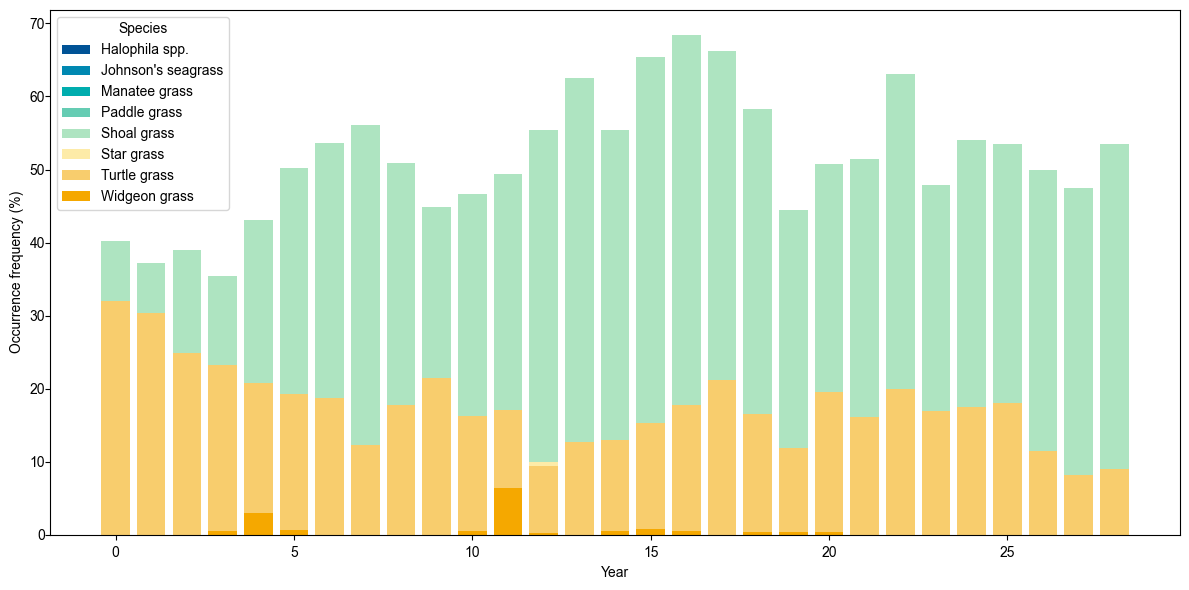

In [146]:
bpdat = props[(props.ManagedAreaName=='Indian River-Vero Beach to Ft. Pierce')]

barplot_sp = plt.figure(figsize=(12, 6))
ax = barplot_sp.add_subplot(111)

# Group the data by analysisunit and relyear, and calculate the mean occurrence frequency (sp_pct)
grouped_data = bpdat.groupby(['analysisunit', 'relyear'])['sp_pct'].mean().reset_index()

# Get unique analysisunit names and their corresponding colors (spcols)
unique_analysisunits = bpdat['analysisunit'].unique()
spcols_subset = {k: v for k, v in spcols.items() if k in unique_analysisunits}

# Plot the grouped data using a bar plot
for idx, group in grouped_data.groupby('analysisunit'):
    color = spcols_subset.get(idx, 'grey')
    label = "Halophila spp." if idx == "Unidentified Halophila" else idx
    ax.bar(group['relyear'], group['sp_pct'], color=color, label=label)

# Set x-axis labels and title
ax.set_xlabel("Year")
ax.set_ylabel("Occurrence frequency (%)")

# Add a legend
ax.legend(title="Species", loc='upper left')

plt.tight_layout()
plt.show()

In [136]:
pattern = 'decipiens|engelmannii|johnsonii|Unidentified|Star|Paddle|Johnson'
bpdat = props[(props.ManagedAreaName=='Indian River-Vero Beach to Ft. Pierce')&(~props.analysisunit.isna())&(~props['analysisunit'].str.contains(pattern, na=False, case=False))]

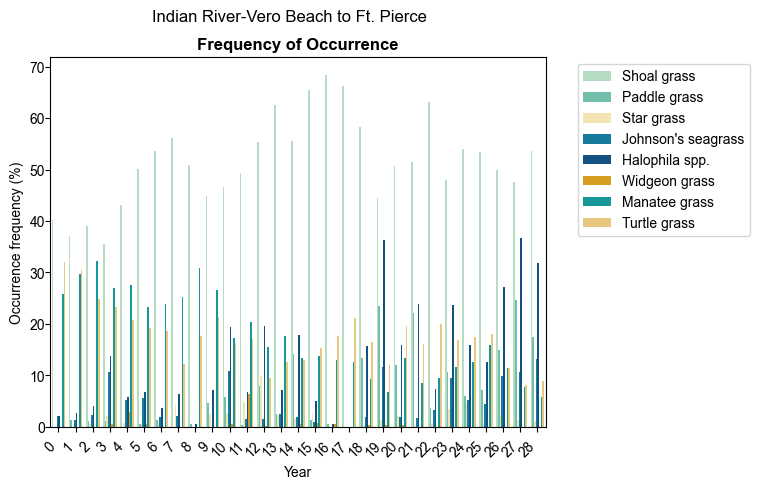

In [132]:
# Create the bar plot using Seaborn
barplot_sp = sns.barplot(data=bpdat, x='relyear', y='sp_pct', hue='analysisunit', palette=spcols)
# bpdat.plot(kind='bar', x='relyear',y='sp_pct', stacked=True)

# Set the title and labels
plt.title('Frequency of Occurrence')
plt.suptitle('Indian River-Vero Beach to Ft. Pierce')
plt.xlabel('Year')
plt.ylabel('Occurrence frequency (%)')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Place the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

# To save the plot to a file, you can use plt.savefig
# plt.savefig("barplot_sp.png", dpi=300, bbox_inches='tight')


In [71]:
pattern = 'decipiens|engelmannii|johnsonii|Unidentified|Star|Paddle|Johnson'
bpdat = props[(props.ManagedAreaName=='Indian River-Vero Beach to Ft. Pierce')&(~props.analysisunit.isna())&(~props['analysisunit'].str.contains(pattern, na=False, case=False))]

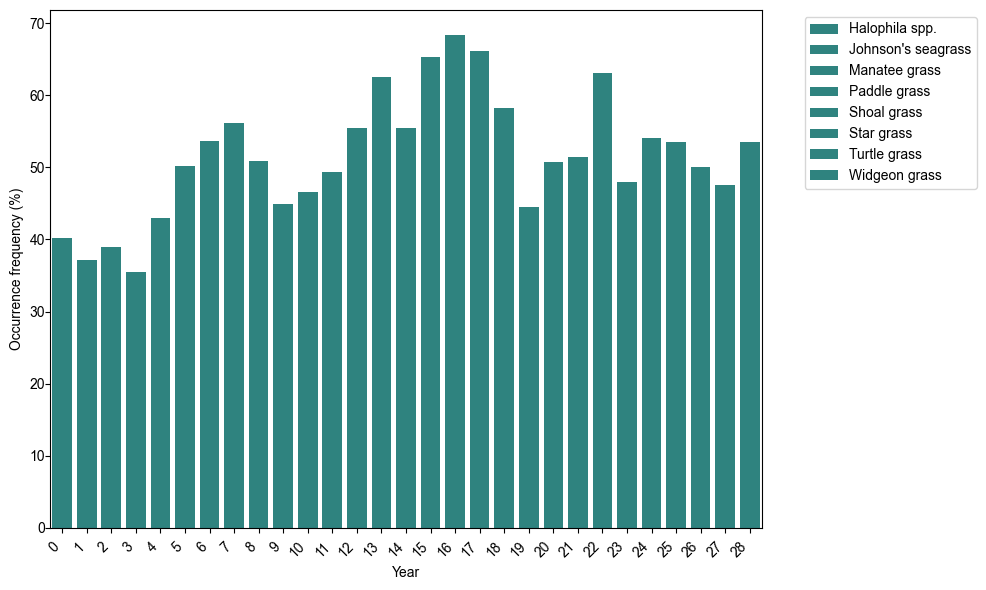

In [218]:
i = 'Indian River-Vero Beach to Ft. Pierce'
if "PA" in Analyses:

#     breaks = list(range(min(SAV4.loc[(SAV4['ManagedAreaName'] == i) & (~SAV4['PA'].isna()), 'relyear']),
#                         max(SAV4.loc[(SAV4['ManagedAreaName'] == i) & (~SAV4['PA'].isna()), 'relyear']),
#                         2))
#     labels = [yrlist[b + 1] for b in breaks]

    bpdat = props[(props['ManagedAreaName'] == i) & (~props['analysisunit'].isna())]
    bpdat = bpdat[bpdat.analysisunit!="Total SAV"]
    bpdat = bpdat[bpdat.analysisunit!="Total seagrass"]

    plt.figure(figsize=(10, 6))
    
    for idx, group in bpdat.groupby(['analysisunit']):
        ax = sns.barplot(data=group, x='relyear', y='sp_pct', hue='analysisunit', palette='viridis')
        
    # Set the title and labels
    plt.xlabel('Year')
    plt.ylabel('Occurrence frequency (%)')

    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Move the legend outside the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Save the plot to a file
    plt.tight_layout()
    plt.savefig(f"SAV/output/Figures/BB/img/SAV_PA_{''.join([c.capitalize() for c in i.split()])}_{'ERR' if 'NERR' in i else 'MS' if 'NMS' in i else 'AP'}_barplot_sp.png", dpi=300, bbox_inches='tight')
    plt.show()

In [124]:
grouped_data = bpdat.groupby(['analysisunit', 'relyear'])['sp_pct'].mean().reset_index()
grouped_data[grouped_data.relyear==0]

,analysisunit,relyear,sp_pct
0,Halophila spp.,0,2.061856
29,Manatee grass,0,25.773196
58,Shoal grass,0,40.206186
87,Turtle grass,0,31.958763
116,Widgeon grass,0,0.000000
